In [3]:
import pandas as pd

data_path = r"C:\Users\Alby Anil\Desktop\Internship\Sentiment Analysis\Data\training.1600000.processed.noemoticon.csv"

df = pd.read_csv(
    data_path,
    encoding='latin-1',
    names=['polarity', 'id', 'date', 'query', 'user', 'text']
)

# Show the first five rows
df.head()


,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Map polarity codes to textual labels
df['sentiment'] = df['polarity'].map({0: 'negative', 2: 'neutral', 4: 'positive'})

# Check the distribution of sentiments
print(df['sentiment'].value_counts())


sentiment
negative    800000
positive    800000
Name: count, dtype: int64


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_tweet(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+", "", text)       # Remove URLs
    text = re.sub(r"@\w+", "", text)                 # Remove user mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)          # Remove special chars and numbers
    text = text.lower()                               # Lowercase
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply the cleaning function to the text column
df['clean_text'] = df['text'].apply(clean_tweet)

# Show a sample of original and cleaned text
df[['text', 'clean_text']].head()


[nltk_data] Downloading package stopwords to C:\Users\Alby
[nltk_data]     Anil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",that bummer shoulda got david carr third day
1,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...
2,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save rest go bound
3,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,"@nationwideclass no, it's not behaving at all....",behav im mad cant see


C:\Users\Alby Anil\AppData\Local\Temp\ipykernel_9268\3421619804.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, order=['negative', 'neutral', 'positive'], palette='Set2')


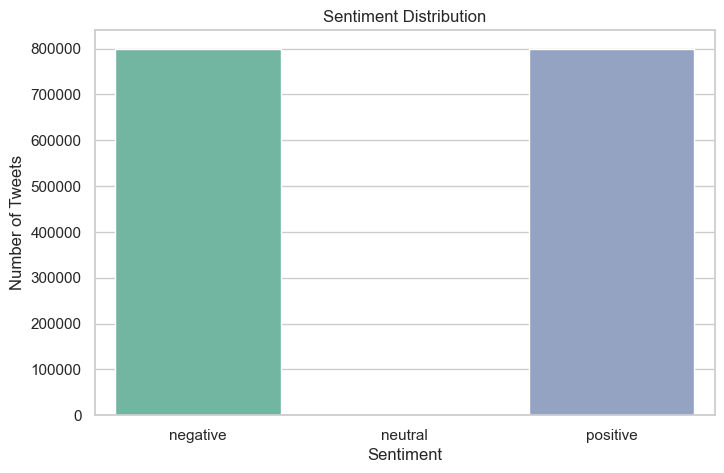

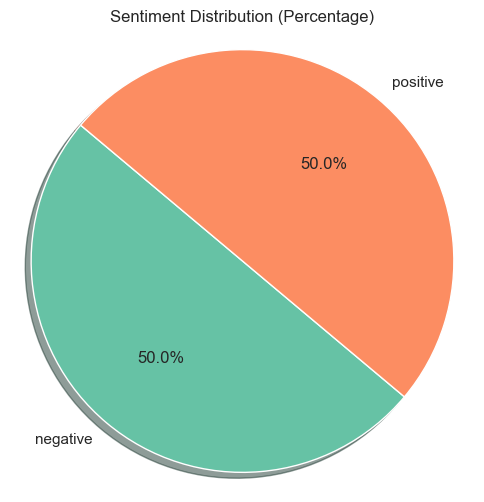

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Sentiment count plot
plt.figure(figsize=(8,5))
sns.countplot(x='sentiment', data=df, order=['negative', 'neutral', 'positive'], palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

# Pie chart of sentiment distribution
plt.figure(figsize=(6,6))
sentiment_counts = df['sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', 
        colors=sns.color_palette('Set2'), startangle=140, shadow=True)
plt.title('Sentiment Distribution (Percentage)')
plt.axis('equal')
plt.show()


In [8]:
!pip install wordcloud

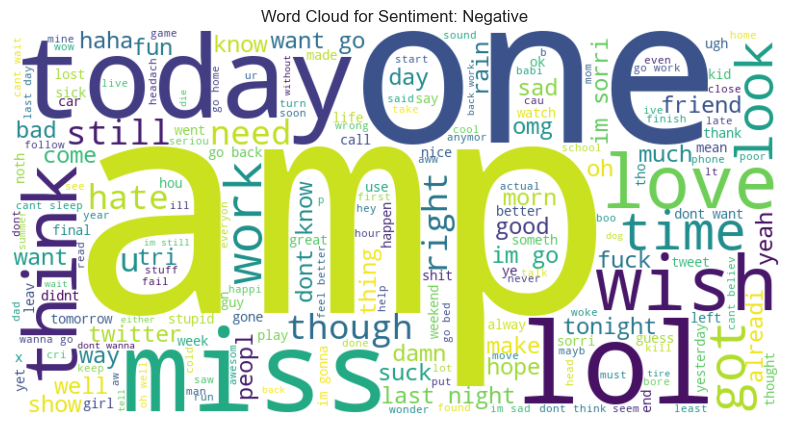

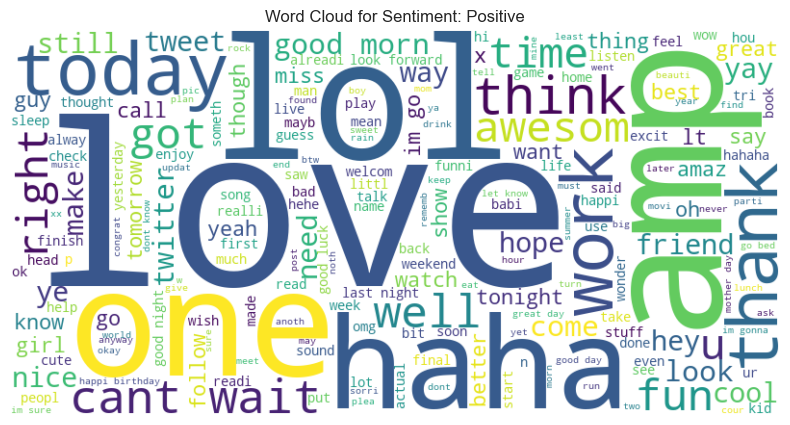

In [9]:
from wordcloud import WordCloud

for label in df['sentiment'].unique():
    text = " ".join(df[df['sentiment'] == label]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Sentiment: {label.capitalize()}')
    plt.show()


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use a sample for speed, or remove .sample(...) for full data
df_sample = df.sample(n=100000, random_state=1) if len(df) > 100000 else df

vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df_sample['clean_text'])
y = df_sample['sentiment']
print("TF-IDF matrix shape:", X.shape)
print(y.value_counts())


TF-IDF matrix shape: (100000, 3000)
sentiment
positive    50152
negative    49848
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Train set size: 80000
Test set size: 20000


In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)


LogisticRegression(max_iter=300)

Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.74      0.76      9970
    positive       0.75      0.78      0.76     10030

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



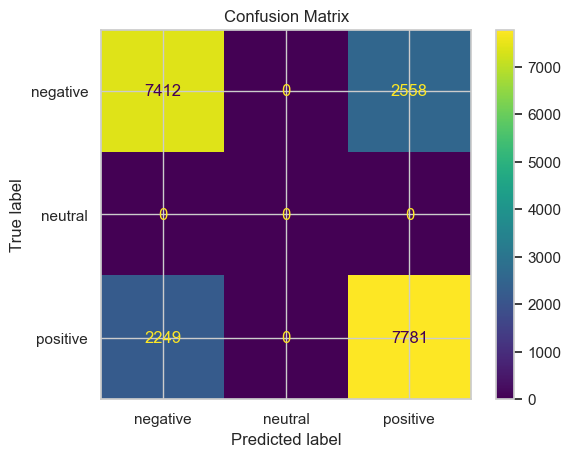

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive']).plot()
plt.title("Confusion Matrix")
plt.show()


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=300, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

results = {}

for name, clf in models.items():
    print(f"Training and evaluating {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    results[name] = clf


Training and evaluating Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    negative       0.77      0.74      0.76      9970
    positive       0.75      0.78      0.76     10030

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Training and evaluating Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

    negative       0.74      0.76      0.75      9970
    positive       0.75      0.74      0.75     10030

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

Training and evaluating SVM...
Classification Report for SVM:
              precision    recall  f1-score   support

    negative       0.78      0.75      0.76      9970

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit GridSearch on training data
grid_rf.fit(X_train, y_train)

# Best estimator assigned to best_rf
best_rf = grid_rf.best_estimator_

print("Best parameters:", grid_rf.best_params_)
print("Best RF model:", best_rf)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best RF model: RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=42)


In [18]:
# y_pred contains predictions on X_test, y_test has true labels.

# misclassified mask: boolean array aligned with y_test
misclassified_indices = (y_pred != y_test)

# Select misclassified samples with label-based indexing
misclassified_texts = df_sample.loc[y_test.index[misclassified_indices]]

import pandas as pd
errors_df = pd.DataFrame({
    'text': misclassified_texts['clean_text'],
    'true_label': y_test[misclassified_indices],
    'predicted_label': y_pred[misclassified_indices]
})

print(errors_df.head(10))


                                                      text true_label  \
1519848  think okjust go leav hubsh handymana littl out...   positive   
1247204   teeth hurt dont care co dad come weekend go show   positive   
45447              parttim blogger weekend publish content   negative   
666635                                                       negative   
1019861  that rather impress due hold breath steadi han...   positive   
257074   got perm back grade call perm rest year howev ...   negative   
438920                          new car glad she ok though   negative   
383392   sabaysabay lahat weather swine flu amp ayaw ta...   negative   
1322297  oh waaaa eeeeeeeeeeeeeeeee sportsgirl intervie...   positive   
1366887            want privat investigatorit sound funlol   positive   

        predicted_label  
1519848        negative  
1247204        negative  
45447          positive  
666635         positive  
1019861        negative  
257074         positive  
438920        

Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.74      0.76      9970
    positive       0.75      0.78      0.76     10030

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



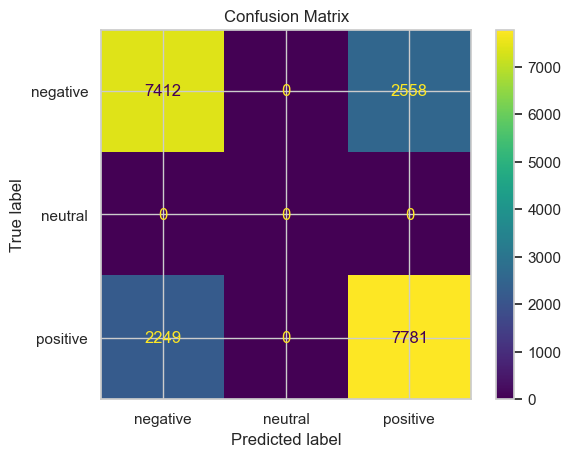

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predict and evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive']).plot()
plt.title("Confusion Matrix")
plt.show()


In [21]:
print("Classes detected by model:", model.classes_)
print("Shape of coef_:", model.coef_.shape)


Classes detected by model: ['negative' 'positive']
Shape of coef_: (1, 3000)


In [22]:
# Features with largest positive coefficients favor 'positive'
top = np.argsort(model.coef_[0])[-10:]
print("Top positive words:", feature_names[top])

# Features with largest negative coefficients favor 'negative'
bottom = np.argsort(model.coef_[0])[:10]
print("Top negative words:", feature_names[bottom])



Top positive words: ['congrat' 'awesom' 'amaz' 'congratul' 'hehe' 'love' 'smile' 'proud'
 'welcom' 'thank']
Top negative words: ['sad' 'miss' 'disappoint' 'upset' 'cancel' 'ugh' 'hurt' 'unfortun'
 'sadli' 'wish']


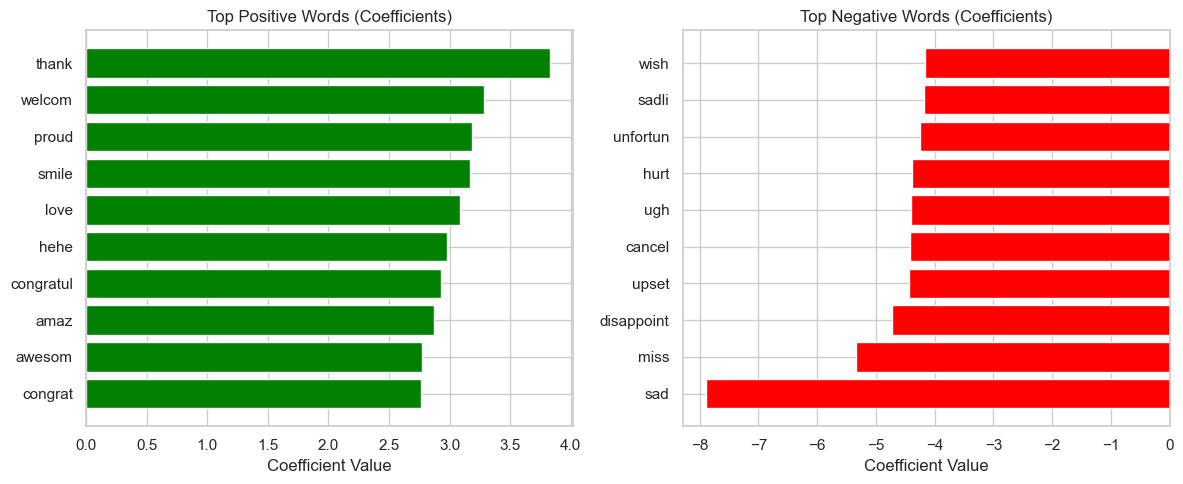

In [23]:
import matplotlib.pyplot as plt
import numpy as np

top_pos_words = ['congrat', 'awesom', 'amaz', 'congratul', 'hehe', 'love', 'smile', 'proud', 'welcom', 'thank']
top_neg_words = ['sad', 'miss', 'disappoint', 'upset', 'cancel', 'ugh', 'hurt', 'unfortun', 'sadli', 'wish']

# Assuming you have the feature_names and coefficients already
pos_indices = [np.where(feature_names == w)[0][0] for w in top_pos_words]
neg_indices = [np.where(feature_names == w)[0][0] for w in top_neg_words]

pos_coefs = model.coef_[0][pos_indices]
neg_coefs = model.coef_[0][neg_indices]

plt.figure(figsize=(12,5))

# Plot positive words
plt.subplot(1,2,1)
plt.barh(top_pos_words, pos_coefs, color='green')
plt.title("Top Positive Words (Coefficients)")
plt.xlabel("Coefficient Value")

# Plot negative words
plt.subplot(1,2,2)
plt.barh(top_neg_words, neg_coefs, color='red')
plt.title("Top Negative Words (Coefficients)")
plt.xlabel("Coefficient Value")

plt.tight_layout()
plt.show()


In [26]:
import os

# Define the models directory path (update if needed)
models_dir = r"C:\Users\Alby Anil\Desktop\Internship\Sentiment Analysis\Models"

# Create the folder if it doesn't exist
os.makedirs(models_dir, exist_ok=True)


In [27]:
import joblib

joblib.dump(model, os.path.join(models_dir, 'logreg_sentiment140.pkl'))
joblib.dump(vectorizer, os.path.join(models_dir, 'tfidf_vectorizer.pkl'))


['C:\\Users\\Alby Anil\\Desktop\\Internship\\Sentiment Analysis\\Models\\tfidf_vectorizer.pkl']